<a href="https://colab.research.google.com/github/NUMLDS/stitching-project-Eleanorhhhyxz/blob/main/(Complete)%20Stitching_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import kagglehub
from tqdm import tqdm
from typing import List
from typing_extensions import TypedDict
from pprint import pprint
from IPython.display import Image, display
import pinecone
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langgraph.graph import Graph, END, StateGraph, START

# Data Pipeline

### Load in the saved dataset

In [3]:
import pandas as pd
filtered_reviews = pd.read_csv("/content/drive/MyDrive/dl_models/GenAI_Stitching/filtered_reviews.csv")
filtered_reviews

<ipython-input-3-70fa84edd852>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_reviews = pd.read_csv("/content/drive/MyDrive/Datasets/filtered_reviews.csv")


,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280134,2276253200,5,1.0,NaN,0,0,0,2023-03-13,Consider salicylic acid your secret weapon for...,NaN,fair,brown,combination,NaN,P505392,Multi Action Clear Acne Clearing Treatment Lot...,StriVectin,49.0
280135,28013163278,5,1.0,NaN,0,0,0,2023-03-13,I’ve been using this as my only moisturizer fo...,NaN,NaN,blue,combination,blonde,P505392,Multi Action Clear Acne Clearing Treatment Lot...,StriVectin,49.0
280136,1539813076,5,1.0,NaN,0,0,0,2023-03-13,I got breakouts whenever it’s my time of month...,NaN,light,blue,combination,blonde,P505392,Multi Action Clear Acne Clearing Treatment Lot...,StriVectin,49.0
280137,5595682861,5,1.0,NaN,0,0,0,2023-03-13,I love this!!! I don’t get actual acne just an...,NaN,fair,hazel,oily,NaN,P505392,Multi Action Clear Acne Clearing Treatment Lot...,StriVectin,49.0


In [4]:
# Extract 0.1% of the most useful reviews for upserting
filtered_reviews = filtered_reviews.sort_values(by="helpfulness", ascending=False)
data = filtered_reviews[:280]

# Build Multi-agent System for Adavanced RAG and LoRA

## Basic RAG Pipeline

In [5]:
# Load necessary keys and tokens from the .env file
from dotenv import load_dotenv
load_dotenv("/content/drive/MyDrive/code_envs/.env")
# Access environment variables
openai_key = os.getenv("OPENAI_API_KEY")
pinecone_key = os.getenv("PINECONE_API_KEY")
ngrok_key = os.getenv("NGROK_TOKEN")

In [6]:
# Launch openai model
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(
    openai_api_key=openai_key,
    model_name="gpt-3.5-turbo",
    temperature=0,
)

<ipython-input-6-2c5a03b84996>:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


In [7]:
pc = pinecone.Pinecone(api_key=pinecone_key)  # Initialize Pinecone client
index_name = "sephora-review-index-test"
text_field = "raw_text_index"
print(pc.list_indexes())

[{
    "name": "sephora-review-index-test",
    "dimension": 768,
    "metric": "cosine",
    "host": "sephora-review-index-test-u16bwp6.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "deletion_protection": "disabled"
}, {
    "name": "review-embedding",
    "dimension": 768,
    "metric": "cosine",
    "host": "review-embedding-u16bwp6.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "deletion_protection": "disabled"
}, {
    "name": "sephora-review-index",
    "dimension": 768,
    "metric": "cosine",
    "host": "sephora-review-index-u16bwp6.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aw

In [8]:
from fastembed import TextEmbedding
class embeddingModel:
    def __init__(self, model):
        # Initialize FastEmbed model
        self.model = TextEmbedding(model_name=model)

    def embed_documents(self, splits):
        # Embed a list of chunks (splits) and return a list of embeddings
        return [list(self.model.embed(chunk))[0].tolist() for chunk in splits] # every time extract the first result from what self.model.embed() returns

    def embed_query(self, query):
        return list(self.model.embed(query))[0].tolist()

# Initialize the embedding model
embeddings = embeddingModel("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

<ipython-input-8-28cce470dcdf>:5: UserWarning: The model sentence-transformers/paraphrase-multilingual-mpnet-base-v2 now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  self.model = TextEmbedding(model_name=model)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
from langchain_pinecone import PineconeVectorStore
index = pc.Index(index_name)
vectorstore = PineconeVectorStore(
    index=index,
    embedding=embeddings,
    text_key="review_text"
)
vectorstore

In [10]:
def basic_rag_retriever(query, k=5):
    """Retrieve top 5 relevant documents from vector DB."""
    retrieved_docs = vectorstore.similarity_search(query, k=k)  # ✅ Works with PineconeVectorStore
    return [doc for doc in retrieved_docs]

def format_docs(docs):
    # Ensure proper formatting by extracting page_content
    return "\n\n".join(doc.page_content if hasattr(doc, 'page_content') else str(doc) for doc in docs)

In [11]:
def basic_rag_pipeline(query):
    retrieved_docs = basic_rag_retriever(query)
    context = format_docs(retrieved_docs)  # Ensure correct document formatting
    response = llm.invoke(f"Context: {context}\n\nQuestion: {query}")
    return response

In [12]:
# Test Basic RAG
query = "What sunscreen products in Sephora are suitable for sensitive skins based on the reviews?"
answer = basic_rag_pipeline(query)
print(answer.content)

Based on the reviews, some sunscreen products at Sephora that are suitable for sensitive skin include:

1. Supergoop! Unseen Sunscreen SPF 40
2. Drunk Elephant Umbra Sheer Physical Daily Defense SPF 30
3. First Aid Beauty Ultra Repair Pure Mineral Sunscreen Moisturizer SPF 40
4. Tatcha Silken Pore Perfecting Sunscreen SPF 35
5. Coola Mineral Face SPF 30 Matte Tint Moisturizer

These products have received positive feedback from users with sensitive skin, so they may be worth considering for your skincare routine.


## Agent 1: Query Rewriting Agent (For Advanced RAG)

In [13]:
import openai
from typing import List
def query_rewriter(query: str) -> str:
    """
    A simple LLM-based agent to rephrase or enhance the user's query before sending it to the Retriever.
    """
    system_message = "You are a helpful assistant that rewrites queries for better search."
    user_message = f"Rewrite this user query to help the retriever agent retrieve the most relevant reviews: \n{query}"
    client = openai.OpenAI(api_key=openai_key)
    response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": user_message}
            ],
            temperature=0.7
        )
    rewritten_query = response.choices[0].message.content.strip().lower()
    return rewritten_query

In [14]:
# Example usage
query = "What sunscreen products in Sephora are suitable for sensitive skins based on the reviews?"
answer = query_rewriter(query)
answer

'find sunscreen products at sephora that are recommended for sensitive skin according to customer reviews.'

## Agent 2: Retriever Agent (Vector Database Retriever)

In [15]:
def retriever_agent(query: str, k: int = 5):
    """
    A simple wrapper around basic_rag_retriever to act as a 'retriever agent.'
    This function only does retrieval and returns the raw docs.
    """
    docs = basic_rag_retriever(query, k)
    return docs

In [16]:
# Example Usage of retriever agent
test_query = "What reviews are correlated with lipstick products?"
docs = retriever_agent(test_query)
docs

[Document(id='155356', metadata={'brand_name': 'fresh', 'price_usd': 28.0, 'product_name': 'Sugar Recovery Lip Mask Advanced Therapy', 'rating': 3.0}, page_content='I LOVE their Advanced Therapy Lip Treatment, I keep this one in my car because the tube kind melts. I like this because it doesn’t irritate my already very dry lips and it won’t melt all over my car, but for actual lip protection I will continue to use the other product.'),
 Document(id='155058', metadata={'brand_name': 'Lancôme', 'price_usd': 140.0, 'product_name': 'Rénergie H.C.F. Triple Serum: For Plumping & Anti-Aging', 'rating': 4.0}, page_content='my makeup. I would do a touch up mid day and be fine. I deducted one star for this issue. But all in all this is a powerful  product that I will continue to purchase!'),
 Document(id='155875', metadata={'brand_name': "Kiehl's Since 1851", 'price_usd': 60.0, 'product_name': 'Super Multi-Corrective Anti-Aging Eye Cream', 'rating': 4.0}, page_content='I am no exception to the r

## Agent 3: Sentiment Analyzer Agent

Used the base model and the finetuned LoRA model to build 2 Sentiment Analyzer Agents

In [17]:
# Set seed for reproducibility
import torch
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [18]:
from transformers import logging
logging.set_verbosity_error()

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
def sentiment_analyzer_base_agent(docs: list[str]) -> list[str]:
    base_model_name = "prajjwal1/bert-tiny"
    tokenizer_base = AutoTokenizer.from_pretrained(base_model_name)
    tokenizer_base.model_max_length = 512
    model_base = AutoModelForSequenceClassification.from_pretrained(
        base_model_name,
        num_labels=3,
        ignore_mismatched_sizes=True
    )
    model_base.eval()

    sentiments = []
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    for doc in docs:
        if not isinstance(doc, str):
            doc = str(doc)

        inputs = tokenizer_base(doc, return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = model_base(**inputs)
        pred = outputs.logits.argmax(dim=-1).item()
        sentiments.append(label_map.get(pred))

    return sentiments

In [20]:
# Test the base model sentiment analyzer
sentiment_analyzer_base_agent(docs)

['neutral', 'positive', 'positive', 'positive', 'positive']

In [21]:
from peft import PeftModel

def sentiment_analyzer_lora_agent(docs: list[str]) -> list[str]:
    base_model_name = "prajjwal1/bert-tiny"
    tokenizer_base = AutoTokenizer.from_pretrained(base_model_name)
    base_model_lora = AutoModelForSequenceClassification.from_pretrained(
        base_model_name,
        num_labels=3,
        ignore_mismatched_sizes=True
    )
    peft_model = PeftModel.from_pretrained(
        base_model_lora,
        "/content/drive/MyDrive/dl_models/GenAI_Stitching/finetuned_lora_model"
    )
    peft_model.eval()

    sentiments = []
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    for doc in docs:
        if not isinstance(doc, str):
            doc = str(doc)

        inputs = tokenizer_base(doc, return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = peft_model(**inputs)
        pred = outputs.logits.argmax(dim=-1).item()
        sentiments.append(label_map.get(pred))

    return sentiments

In [22]:
# the finetuned lora model agent classfies different reviews into different classes
sentiment_analyzer_lora_agent(docs)

/usr/local/lib/python3.11/dist-packages/peft/config.py:162: UserWarning: Unexpected keyword arguments ['corda_config', 'trainable_token_indices'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


['neutral', 'neutral', 'positive', 'positive', 'neutral']

## Agent 4: Summarizer Agent

In [23]:
# Basic LLM Summarizer
def llm_summarizer(query: str) -> str:
    """
    Answer the user query directly with simple LLM summarizer.
    """
    prompt = (
        f"User query: {query}\n"
        "Please provide an answer to the user's query."
    )
    system_message = "You are a helpful assistant that answers the user's query."
    client = openai.OpenAI(api_key=openai_key)
    response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": prompt}
            ],
            temperature=0.5
        )
    return response.choices[0].message.content.strip()

In [24]:
# RAG+LLM Summarizer
def rag_llm_summarizer(query: str, docs: List[str]) -> str:
    """
    Use Basic RAG with Vectordb-based retriever and LLM for summarization.
    """
    docs_text = "\n".join(f"- {doc}" for doc in docs)
    prompt = (
        f"User query: {query}\n\nRelevant information:\n{docs_text}\n\n"
        "Please provide a concise answer to the user's query."
    )
    client = openai.OpenAI(api_key=openai_key)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "system", "content": "You are a helpful assistant."},
                  {"role": "user", "content": prompt}],
        temperature=0.5
    )
    return response.choices[0].message.content.strip()

In [25]:
def agentic_rag_llm_summarizer(user_query: str, docs: List, sentiments: List[str]):
    """
    Use advanced RAG techniques and sentiment analysis results to generate a comprehensive summary.
    """
    # Format the docs & sentiments for the prompt
    combined_text = ""
    for i, doc in enumerate(docs):
        text = doc.page_content if hasattr(doc, "page_content") else str(doc)
        combined_text += f"Review #{i+1}: {text}\nSentiment: {sentiments[i]}\n\n"

    prompt = (
        f"User query: {user_query}\n\n"
        f"Here are the relevant reviews with the underlying sentiment analyzed:\n{combined_text}\n"
        "Please provide an answer to the user query, incorporating summarization of all the reviews correlated with the user query, "
        "and reflects the overall sentiment of these reviews."
    )

    client = openai.OpenAI(api_key=openai_key)
    response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}],
    temperature=0.5)

    final_answer = response.choices[0].message.content.strip()
    return final_answer

# Build the Graph with LangGraph

### State Definition

In [26]:
# Define the GraphState with keys adapted for our agents
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        query: The input query to retrieve reviews.
        reviews: A list of retrieved reviews.
        sentiment: The sentiment analysis result.
        summary: The final summary generated.
    """
    query: str                 # The input query
    reviews: List[str]         # A list of retrieved reviews
    sentiment: List[str]       # The sentiment analysis result
    summary: str               # The final summary generated
    pipeline_choice: str       # 'a', 'b', 'c', or 'd'

### Node Definition

In [27]:
def choose_pipeline(state: GraphState) -> GraphState:
    """
    Decide which pipeline to run (a, b, c, or d).
    For example, you could read user input or config from 'state["query"]'
    or an external parameter.
    Here we assume it's already in 'state["pipeline_choice"]'.
    """
    pipeline = state["pipeline_choice"].lower()

    # Just log the chosen pipeline:
    print(f"---DECISION: Using pipeline '{pipeline}'---")
    return {"pipeline_choice":pipeline}

In [28]:
def rewrite_query(state: GraphState) -> GraphState:
    """
    Rewrite the user query using the query_rewriter agent.
    """
    print("---REWRITE QUERY---")
    query = state["query"]
    pipeline = state["pipeline_choice"]
    rewritten_query = query_rewriter(query)
    return {"query": rewritten_query, "pipeline_choice":pipeline}

def retrieve_reviews(state: GraphState) -> GraphState:
    """
    Retrieve reviews based on the input query.
    """
    print("---RETRIEVE REVIEWS---")
    query = state["query"]
    pipeline = state["pipeline_choice"]
    # Call the retriever_agent function directly.
    reviews = retriever_agent(query)
    return {"query": query, "pipeline_choice":pipeline, "reviews": reviews}

def analyze_sentiment_base(state: GraphState) -> GraphState:
    """
    Analyze the sentiment of the retrieved reviews with the base language model.
    """
    print("---ANALYZE SENTIMENT WITH BASE MODEL---")
    query = state["query"]
    pipeline = state["pipeline_choice"]
    reviews = state["reviews"]
    sentiment = sentiment_analyzer_base_agent(reviews)
    return {"query": query, "pipeline_choice":pipeline, "reviews": reviews, "sentiment": sentiment}

def analyze_sentiment_lora(state: GraphState) -> GraphState:
    """
    Analyze the sentiment of the retrieved reviews with the lora-finetuned language model.
    """
    print("---ANALYZE SENTIMENT WITH LORA MODEL---")
    query = state["query"]
    pipeline = state["pipeline_choice"]
    reviews = state.get("reviews", [])
    sentiment = sentiment_analyzer_lora_agent(reviews)
    return {"query": query, "pipeline_choice":pipeline, "reviews": reviews, "sentiment": sentiment}

def llm_summarize(state: GraphState) -> GraphState:
    """
    Answer the user query directly with simple LLM summarizer.
    """
    print("---ANSWER QUERY WITH SIMPLE LLM SUMMARIZER---")
    query = state["query"]
    pipeline = state["pipeline_choice"]
    summary = llm_summarizer(query)
    return {"query": query, "pipeline_choice":pipeline, "summary": summary}

def rag_llm_summarize(state: GraphState) -> GraphState:
    """
    Summarize the reviews using RAG to improve LLM response.
    """
    print("---ANSWER QUERY WITH RAG+LLM SUMMARIZER---")
    query = state["query"]
    pipeline = state["pipeline_choice"]
    reviews = state["reviews"]
    summary = rag_llm_summarizer(query, reviews)
    return {"query": query, "pipeline_choice": pipeline, "reviews": reviews, "summary": summary}

def agentic_rag_llm_summarize(state: GraphState) -> GraphState:
    """
    Summarize the reviews using the retrieved content and sentiment result.
    """
    print("---ANSWER QUERY WITH AGENTIC RAG+SENTIMENT SUMMARIZER---")
    query = state["query"]
    pipeline = state["pipeline_choice"]
    reviews = state["reviews"]
    sentiment = state["sentiment"]
    summary = agentic_rag_llm_summarizer(query, reviews, sentiment)
    return {"query": query, "pipeline_choice":pipeline, "reviews": reviews, "sentiment": sentiment, "summary":summary}

### Edge Definition

In [29]:
def pipeline_choice_edge(state: GraphState):
    """
    Decides the next node based on the pipeline choice:
      - For 'a' (Base LLM): go directly to llm_summarize.
      - For 'b' (Basic RAG): go to retrieve_reviews.
      - For 'c' or 'd' (Advanced Agentic RAG): go to rewrite_query.
    """
    choice = state["pipeline_choice"].lower()
    mapping = {
         "a": "llm_summarize",
         "b": "retrieve_reviews",
         "c": "rewrite_query",
         "d": "rewrite_query"
    }
    return mapping.get(choice, END)

def sentiment_analysis_edge(state: GraphState):
    """
    For the advanced agentic pipelines, after retrieving reviews, choose the model for sentiment analysis:
      - For 'c': use the base language model for sentiment analysis.
      - For 'd': use the finetuned lora model for sentiment analysis.
    """
    choice = state["pipeline_choice"].lower()
    if choice == "c":
        return "analyze_sentiment_base"
    elif choice == "d":
        return "analyze_sentiment_lora"
    else:
        return END

### Graph Building

In [30]:
from langgraph.graph import Graph, END, StateGraph, START
# Create a new workflow using your custom GraphState
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("choose_pipeline", choose_pipeline)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("base_rag_retrieve", retrieve_reviews)  # For pipeline (b)
workflow.add_node("advanced_rag_retrieve", retrieve_reviews)  # For pipelines (c) and (d)
workflow.add_node("analyze_sentiment_base", analyze_sentiment_base)  # For pipeline (c)
workflow.add_node("analyze_sentiment_lora", analyze_sentiment_lora)  # For pipeline (d)
workflow.add_node("llm_summarize", llm_summarize) # For pipeline (a)
workflow.add_node("rag_llm_summarize", rag_llm_summarize) # For pipeline (b)
workflow.add_node("agentic_rag_llm_summarize", agentic_rag_llm_summarize) # For pipelines (c) and (d)

# Start with choose_pipeline
workflow.add_edge(START, "choose_pipeline")
workflow.add_conditional_edges(
    "choose_pipeline",
    lambda state: state["pipeline_choice"].lower(),
    {
        "a": "llm_summarize",
        "b": "base_rag_retrieve",
        "c": "rewrite_query",
        "d": "rewrite_query"
    }
)

# Pipeline (a): Base LLM
# If pipeline_choice == 'a', then we directly go to llm_summarize, then END.
workflow.add_edge("llm_summarize", END)

# Pipeline (b): Basic RAG: base_rag_retrieve → rag_llm_summarize → END.
workflow.add_edge("base_rag_retrieve", "rag_llm_summarize")
workflow.add_edge("rag_llm_summarize", END)

# Pipelines (c) and (d): Advanced Agentic RAG.
# They first pass through rewrite_query, then share the advanced_rag_retrieve node.
workflow.add_edge("rewrite_query", "advanced_rag_retrieve")
# Conditional edge from retrieve_reviews
workflow.add_conditional_edges(
    "advanced_rag_retrieve",
    lambda state: state["pipeline_choice"].lower(),
    {
        "c": "analyze_sentiment_base",
        "d": "analyze_sentiment_lora"
    }
)
# Then, both paths converge into agentic_rag_llm_summarize → END.
workflow.add_edge("analyze_sentiment_base", "agentic_rag_llm_summarize")
workflow.add_edge("analyze_sentiment_lora", "agentic_rag_llm_summarize")
workflow.add_edge("agentic_rag_llm_summarize", END)

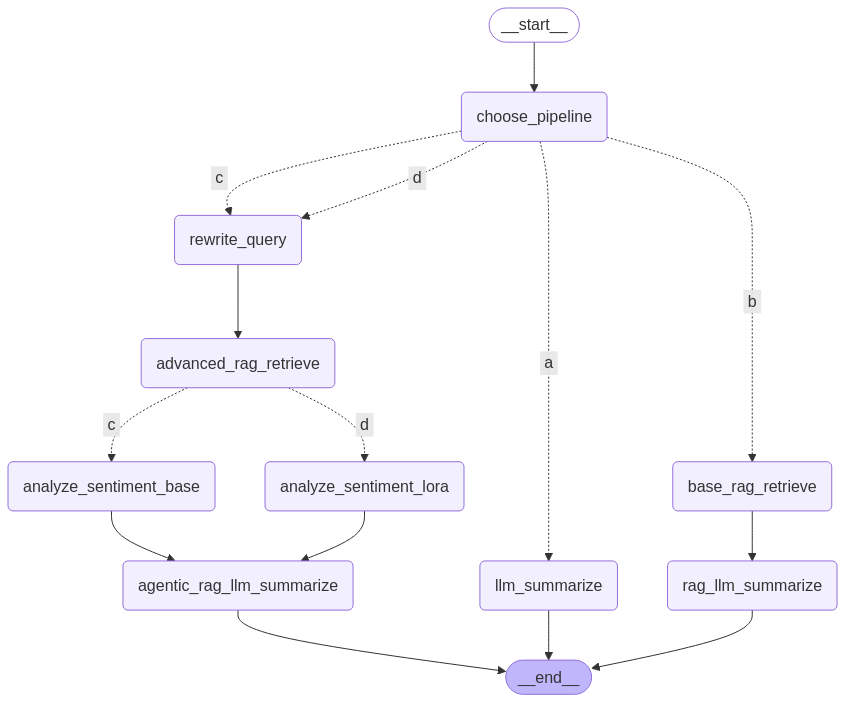

In [42]:
# Compile the workflow
from IPython.display import display, Image
compiled_graph = workflow.compile()
# Display the graph with MermaidDrawMethod
display(
    Image(
        compiled_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [53]:
!pip install dill

In [38]:
import dill as pickle
# Save the Compiled Graph on Colab
save_path = "/content/drive/MyDrive/dl_models/compiled_graph.pkl"
with open(save_path, "wb") as f:
    pickle.dump(compiled_graph, f)
print(f"Graph compiled and saved at {save_path}")

Graph compiled and saved at /content/drive/MyDrive/dl_models/compiled_graph.pkl


# Building the Front-End System

In [4]:
!pip install pyngrok flask

In [4]:
from pyngrok import ngrok
ngrok.set_auth_token(ngrok_key) # replace with your own token

In [46]:
from flask import Flask, request, render_template_string
from pyngrok import ngrok
import dill as pickle
from IPython.display import Image
from pprint import pprint

# Initialize Flask app
app_web = Flask(__name__)

# Expose the app via ngrok (if desired)
public_url = ngrok.connect(5000)
print("Public URL:", public_url)

# HTML template with a query input and a dropdown for pipeline selection.
HTML_TEMPLATE = """
<html>
  <head>
    <title>Multi-Agent Query System</title>
    <style>
      body { font-size: 16px; font-family: sans-serif; }
      .container { width: 80%; margin: auto; }
      .query, .result { font-size: 16px; }
      .review { margin-bottom: 15px; }
      pre { background: #f0f0f0; padding: 10px; }
    </style>
  </head>
  <body>
    <div class="container">
      <h1>Multi-Agent Query System</h1>
      <form method="POST">
        <label for="prompt">Enter your query:</label>
        <input type="text" id="prompt" name="prompt" style="width:400px;" placeholder="Enter query here" required />
        <br><br>
        <label for="pipeline_choice">Select the method you want to get the response:</label>
        <select id="pipeline_choice" name="pipeline_choice">
          <option value="a">Base LLM (no RAG)</option>
          <option value="b">Basic RAG (retriever + LLM summarizer)</option>
          <option value="c">Advanced Agentic RAG (base model)</option>
          <option value="d">Advanced Agentic RAG (LoRA-finetuned)</option>
        </select>
        <br><br>
        <input type="submit" value="Submit" />
      </form>

      {% if prompt %}
        <div class="query">
          <h2>Query:</h2>
          <p>{{ prompt }}</p>
        </div>
        <hr>
      {% endif %}

      {% if result %}
         <div class="result">
          <h2>Query Results:</h2>
          {% if result.reviews %}
             <h3>Related Reviews:</h3>
             <ul>
             {% for review in result.reviews %}
                <li class="review"><p>{{ review }}</p></li>
             {% endfor %}
             </ul>
          {% endif %}
          <p><strong>Analyzed Sentiment:</strong> {{ result.sentiment }}</p>
          <p><strong>Final Summary:</strong> {{ result.summary }}</p>
         </div>
      {% endif %}
    </div>
  </body>
</html>
"""

@app_web.route("/", methods=["GET", "POST"])
def index():
    result = None
    prompt = None
    if request.method == "POST":
        prompt = request.form.get("prompt")
        pipeline_choice = request.form.get("pipeline_choice")  # "a", "b", "c", or "d"
        # Build the initial state for the graph.
        inputs = {
            "query": prompt,
            "pipeline_choice": pipeline_choice,
            # Other keys like reviews, sentiment, summary can be left undefined (or empty)
            "reviews": [],
            "sentiment": [],
            "summary": ""
        }
        runconfig = {"recursion_limit": 50}
        final_output = {}
         # Stream execution: each yield is a dict {node_name: state_dict}
        for output in compiled_graph.stream(inputs, config=runconfig):
            for node_name, state_dict in output.items():
                print(f"Node '{node_name}' visited. State keys: {list(state_dict.keys())}")
                final_output = state_dict  # Keep track of the latest state

        if final_output and "summary" in final_output:
            result = final_output
        else:
            result = {"reviews": [], "sentiment": "N/A", "summary": "No summary available."}

    return render_template_string(HTML_TEMPLATE, prompt=prompt, result=result)

if __name__ == "__main__":
    app_web.run()

Public URL: NgrokTunnel: "https://109f-34-147-109-70.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 17:25:56] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 17:25:56] "GET /favicon.ico HTTP/1.1" 404 -


---DECISION: Using pipeline 'b'---
Node 'choose_pipeline' visited. State keys: ['pipeline_choice']
---RETRIEVE REVIEWS---
Node 'base_rag_retrieve' visited. State keys: ['query', 'pipeline_choice', 'reviews']
---ANSWER QUERY WITH RAG+LLM SUMMARIZER---


INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 17:26:02] "POST / HTTP/1.1" 200 -


Node 'rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'summary']
---DECISION: Using pipeline 'c'---
Node 'choose_pipeline' visited. State keys: ['pipeline_choice']
---REWRITE QUERY---
Node 'rewrite_query' visited. State keys: ['query', 'pipeline_choice']
---RETRIEVE REVIEWS---
Node 'advanced_rag_retrieve' visited. State keys: ['query', 'pipeline_choice', 'reviews']
---ANALYZE SENTIMENT WITH BASE MODEL---
Node 'analyze_sentiment_base' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment']
---ANSWER QUERY WITH AGENTIC RAG+SENTIMENT SUMMARIZER---


INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 17:26:21] "POST / HTTP/1.1" 200 -


Node 'agentic_rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment', 'summary']
---DECISION: Using pipeline 'a'---
Node 'choose_pipeline' visited. State keys: ['pipeline_choice']
---ANSWER QUERY WITH SIMPLE LLM SUMMARIZER---


INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 18:16:13] "POST / HTTP/1.1" 200 -


Node 'llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'summary']
---DECISION: Using pipeline 'b'---
Node 'choose_pipeline' visited. State keys: ['pipeline_choice']
---RETRIEVE REVIEWS---
Node 'base_rag_retrieve' visited. State keys: ['query', 'pipeline_choice', 'reviews']
---ANSWER QUERY WITH RAG+LLM SUMMARIZER---


INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 18:17:18] "POST / HTTP/1.1" 200 -


Node 'rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'summary']
---DECISION: Using pipeline 'b'---
Node 'choose_pipeline' visited. State keys: ['pipeline_choice']
---RETRIEVE REVIEWS---
Node 'base_rag_retrieve' visited. State keys: ['query', 'pipeline_choice', 'reviews']
---ANSWER QUERY WITH RAG+LLM SUMMARIZER---


INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 18:18:56] "POST / HTTP/1.1" 200 -


Node 'rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'summary']
---DECISION: Using pipeline 'c'---
Node 'choose_pipeline' visited. State keys: ['pipeline_choice']
---REWRITE QUERY---
Node 'rewrite_query' visited. State keys: ['query', 'pipeline_choice']
---RETRIEVE REVIEWS---
Node 'advanced_rag_retrieve' visited. State keys: ['query', 'pipeline_choice', 'reviews']
---ANALYZE SENTIMENT WITH BASE MODEL---
Node 'analyze_sentiment_base' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment']
---ANSWER QUERY WITH AGENTIC RAG+SENTIMENT SUMMARIZER---


INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 18:20:37] "POST / HTTP/1.1" 200 -


Node 'agentic_rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment', 'summary']
---DECISION: Using pipeline 'd'---
Node 'choose_pipeline' visited. State keys: ['pipeline_choice']
---REWRITE QUERY---
Node 'rewrite_query' visited. State keys: ['query', 'pipeline_choice']
---RETRIEVE REVIEWS---
Node 'advanced_rag_retrieve' visited. State keys: ['query', 'pipeline_choice', 'reviews']
---ANALYZE SENTIMENT WITH LORA MODEL---


/usr/local/lib/python3.11/dist-packages/peft/config.py:162: UserWarning: Unexpected keyword arguments ['corda_config', 'trainable_token_indices'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


Node 'analyze_sentiment_lora' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment']
---ANSWER QUERY WITH AGENTIC RAG+SENTIMENT SUMMARIZER---


INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 18:22:44] "POST / HTTP/1.1" 200 -


Node 'agentic_rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment', 'summary']


# Test Running with Sample Prompts

In [44]:
from pprint import pprint
test_prompts = [
    "What is the most suitable sunscreen product for sensitive skin in Sephora?",
    "How do users feel about lipstick products in Sephora based on the reviews?",
    "Which are the most trendy types of perfume, and how do users feel about them?",
    "What oil do users like to use at season transition times?",
    "Which are users complaining about the powder, and why?"
]

def run_tests():
    """
    Run the compiled pipeline in streaming mode for each test prompt and for each pipeline variant.
    Prints intermediate node outputs and the final summary.

    Pipeline choices:
      a. Base LLM (no RAG)
      b. Basic RAG (retriever + LLM summarizer)
      c. Advanced agentic RAG with base model (no fine-tuning)
      d. Advanced agentic RAG with fine-tuned model
    """
    runconfig = {"recursion_limit": 50}
    pipeline_choices = ['a', 'b', 'c', 'd']
    pipeline_names = {'a':'Base LLM (no RAG)', 'b': 'Basic RAG (retriever + LLM summarizer)', 'c':'Advanced agentic RAG with base model (no fine-tuning)', 'd': 'Advanced agentic RAG with fine-tuned model'}

    for idx, prompt in enumerate(test_prompts, start=1):
        print(f"\n=== Running Test Prompt {idx}: {prompt} ===")
        for choice in pipeline_choices:
            pipeline_name = pipeline_names[choice]
            print(f"\n--- Running pipeline {choice}: {pipeline_name} ---")
            # Set initial state with the prompt and the chosen pipeline
            inputs = {
                "query": prompt,
                "pipeline_choice": choice,
                #"reviews": [],
                #"sentiment": [],
                #"summary": ""
            }
            final_output = None

            # Stream execution: each yield is a dict {node_name: state_dict}
            for output in compiled_graph.stream(inputs, config=runconfig):
                for node_name, state_dict in output.items():
                    print(f"Node '{node_name}' visited. State keys: {list(state_dict.keys())}")
                    final_output = state_dict

            if final_output and "summary" in final_output:
                print("\nFinal Summary:")
                pprint(final_output["summary"])
            else:
                print("\nNo 'summary' key found in the final output.")

        print("\n====================================")

if __name__ == "__main__":
    run_tests()


=== Running Test Prompt 1: What is the most suitable sunscreen product for sensitive skin in Sephora? ===

--- Running pipeline a: Base LLM (no RAG) ---
---DECISION: Using pipeline 'a'---
Node 'choose_pipeline' visited. State keys: ['pipeline_choice']
---ANSWER QUERY WITH SIMPLE LLM SUMMARIZER---
Node 'llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'summary']

Final Summary:
('For sensitive skin, a good option for sunscreen at Sephora would be the '
 'Supergoop! Unseen Sunscreen SPF 40. This sunscreen is lightweight, oil-free, '
 'and fragrance-free, making it suitable for sensitive skin. It also provides '
 'broad-spectrum protection and is gentle enough for daily use.')

--- Running pipeline b: Basic RAG (retriever + LLM summarizer) ---
---DECISION: Using pipeline 'b'---
Node 'choose_pipeline' visited. State keys: ['pipeline_choice']
---RETRIEVE REVIEWS---
Node 'base_rag_retrieve' visited. State keys: ['query', 'pipeline_choice', 'reviews']
---ANSWER QUERY WITH RAG

/usr/local/lib/python3.11/dist-packages/peft/config.py:162: UserWarning: Unexpected keyword arguments ['corda_config', 'trainable_token_indices'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


Node 'analyze_sentiment_lora' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment']
---ANSWER QUERY WITH AGENTIC RAG+SENTIMENT SUMMARIZER---
Node 'agentic_rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment', 'summary']

Final Summary:
('Based on the reviews from Sephora customers, the best sunscreen for '
 'sensitive skin would be a product that not only provides sun protection but '
 'also caters to sensitive skin needs. Customers have highlighted the '
 'importance of finding a sunscreen that is gentle on the skin and works well '
 'with other skincare products. \n'
 '\n'
 'Overall, the reviews indicate that the ideal sunscreen for sensitive skin at '
 'Sephora should be a versatile product that can also function as a '
 'moisturizer and contribute to skin renewal. Customers have praised products '
 'that are gentle, effective, and do not cause irritation or dryness. '
 'Additionally, users have appreciated sunscreens that h

/usr/local/lib/python3.11/dist-packages/peft/config.py:162: UserWarning: Unexpected keyword arguments ['corda_config', 'trainable_token_indices'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


Node 'analyze_sentiment_lora' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment']
---ANSWER QUERY WITH AGENTIC RAG+SENTIMENT SUMMARIZER---
Node 'agentic_rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment', 'summary']

Final Summary:
('Based on the reviews of lipstick products at Sephora, the general sentiments '
 'are mixed. Two reviews expressed positive sentiments towards the product, '
 'highlighting benefits such as not causing breakouts, pleasant scent, and '
 'positive effects on fine lines. One review had a neutral sentiment, '
 'mentioning that the product made their face glowy but was too fragrant for '
 'their liking. The remaining two reviews also had neutral sentiments, with '
 "one customer feeling disappointed in the product's performance compared to "
 'its price and another customer expressing concerns about the packaging and '
 'the number of steps in their skincare routine.\n'
 '\n'
 'Overall, the sentiment

/usr/local/lib/python3.11/dist-packages/peft/config.py:162: UserWarning: Unexpected keyword arguments ['corda_config', 'trainable_token_indices'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


Node 'analyze_sentiment_lora' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment']
---ANSWER QUERY WITH AGENTIC RAG+SENTIMENT SUMMARIZER---
Node 'agentic_rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment', 'summary']

Final Summary:
('Based on the reviews provided, the most popular types of perfume seem to '
 'have mixed sentiments among users. While some users appreciate the pleasant '
 'scent and skincare benefits of the products, others find the fragrance to be '
 'too strong or not to their liking. \n'
 '\n'
 'Reviewers who enjoyed the perfumes mentioned positive experiences such as '
 'smoother, moisturized skin, pleasant scents, and ease of makeup application. '
 'They also noted benefits like hydration, plumping effects, and a reduction '
 'in fine lines. These users expressed satisfaction with the product and '
 'indicated a willingness to repurchase.\n'
 '\n'
 'On the other hand, reviewers with neutral sentiments po

/usr/local/lib/python3.11/dist-packages/peft/config.py:162: UserWarning: Unexpected keyword arguments ['corda_config', 'trainable_token_indices'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


Node 'analyze_sentiment_lora' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment']
---ANSWER QUERY WITH AGENTIC RAG+SENTIMENT SUMMARIZER---
Node 'agentic_rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment', 'summary']

Final Summary:
('Based on the reviews analyzed, it seems that users prefer using oil-based '
 'products during seasonal transitions, particularly those with oily skin. \n'
 '\n'
 'Review #1 and Review #2 express positive sentiments towards an oil-based '
 'product, highlighting its effectiveness in controlling oiliness and '
 'improving skin condition, especially for oily skin types. Review #3, '
 'although not entirely negative, suggests that the oil-based product may be '
 'too drying for those living in a desert climate, but it is still recommended '
 'for oily skin types. Review #4 mentions positive results for sensitive, dry '
 'skin, indicating that the oil worked well during winter. Review #5 also '
 'sh

/usr/local/lib/python3.11/dist-packages/peft/config.py:162: UserWarning: Unexpected keyword arguments ['corda_config', 'trainable_token_indices'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


Node 'analyze_sentiment_lora' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment']
---ANSWER QUERY WITH AGENTIC RAG+SENTIMENT SUMMARIZER---
Node 'agentic_rag_llm_summarize' visited. State keys: ['query', 'pipeline_choice', 'reviews', 'sentiment', 'summary']

Final Summary:
('Based on the reviews analyzed, the complaints about the powder are as '
 'follows:\n'
 '\n'
 '1. Review #2: The user experienced burning and splotches under their eyes '
 'after using the powder. They were disappointed with the product and advised '
 'others to test it first.\n'
 '2. Review #4: Another user disliked the texture of the powder, describing it '
 'as bad and sticky, even the next morning.\n'
 '\n'
 'Overall, users complained about experiencing adverse reactions such as '
 'burning and splotches, as well as disliking the texture of the powder. These '
 'negative aspects led to disappointment and dissatisfaction among users who '
 'left these reviews.')

